![Australia elevation logo](/img/elevation/australia-elevation.jpg)

Please check out [this summary of the basic concepts](https://www.neonscience.org/resources/learning-hub/tutorials/chm-dsm-dtm-gridded-lidar-data) for Digital Elevation Models (DEM) from Neon. First however is the distinction between DTMs and DSMs. Their figure highlights the main points.

![Australia elevation logo](/img/elevation/dsm.png)

Additionally, there are a great many DEM datasets available globally, particularly for the US and Europe. These options are nicely highlighted [at this repository](https://github.com/DahnJ/Awesome-DEM).

## Goals

What we ideally need is a single tiff tile that provides decent elevation estimates for a given latitude and longitude across all of Australia. 

![Australia elevation grid](/img/elevation/gridding.gif)

We can then simply point to this (large) tiff, and apply an elevation model in Python.

```python
from osgeo import gdal

class ElevationModel:
    def __init__(self, filename, geojson_file):
        self.ds = gdal.Open(filename)

    def get_elevation(self, lon, lat):
        gt = self.ds.GetGeoTransform()
        x = int((lon - gt[0]) / gt[1])
        y = int((lat - gt[3]) / gt[5])

        return self.ds.ReadAsArray(x, y, 1, 1)[0][0]
```

Which we can then call, via something like:

```python
model = ElevationModel('elevation.tif')

# Let's try Sydney (151.209900, -33.865143)
lon,lat = (151.209900, -33.865143)

# Calculate elevation
elevation = model.get_elevation(lon, lat)

print(f"Elevation at {lon}, {lat} is {elevation}")
> 6.23
```

This can then be used and extended to calculate viewsheds, walkability metrics and provide to our property pricing models to name a few.

## Sources 
### ELVIS

One primary source for Australia is the [ELVIS](https://elevation.fsdf.org.au/) data.


![ELVIS](/img/elevation/elvis.jpg)

This data consists of the following: 

* Combined state and national datasets
* Generally lidar-derived data
* Resolutions include: 1m, 2m, 5m, 1 second
* Complete coverage for NSW, Victoria and Tasminia with partial coverage in other state/territories
* Bathymetry also provided for surrounding waters

One can access the [LiDAR 5 Metre Grid models](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644) from GeoScience Australia, though the piecemeal nature of it makes creating a generalised elevation map for each city is challenging. It entails downloading every bounding box region of interest for each city then more backend handling to get what is needed for wombat.

The only government dataset that seems to provides a manageable dataset (fully integrated tile) and achieves out goal is the following:

* [1 second SRTM Level 2 Derived Digital Elevation Model v1.0](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/69816)

Which has since been updated (2010) to address several issues in the original dataset.

* [1 second SRTM Level 2 Derived Smoothed Digital Elevation Model (DEM-S) version 1.0 (41GB)](https://researchdata.edu.au/1-second-srtm-version-10/1439881)

> *The 1 second Shuttle Radar Topographic Mission (SRTM) derived smoothed Digital Elevation Model (DEM-S) Version 1.0 is a 1 arc second (~30m) gridded smoothed version of the DEM (ANZCW0703013355). The DEM-S represents ground surface topography, excluding vegetation features, and has been smoothed to reduce noise and improve the representation of surface shape. The dataset was derived from the 1 second Digital Elevation Model Version 1.0 (DSM; ANZCW0703013336) by an adaptive smoothing process that applies more smoothing in flatter areas than hilly areas, and more smoothing in noisier areas than in less noisy areas. This DEM-S supports calculation of local terrain shape attributes such as slope, aspect and curvatures that could not be reliably derived from the unsmoothed DEM because of noise. A full description of the methods is in progress (Gallant et al., in prep) and in the User Guide (Geoscience Australia & CSIRO, 2010).* ~Gallant, J. ; Tickle, P.K. ; Wilson, N. ; Dowling, T. ; Read, A. (2010)

Upon downloading this 40GB file, we can check the extent to verify it's coverage:

```python
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely.geometry import shape, box

import wombat

w = wombat.Wombat()

# Path to elevation tif file
tif_file = w.Datasets.elevation_tif_filename

# State and territory boundaries
w.Boundary.load_states_territories()
gdf = w.Boundary.gdf_states_territories

fig,ax = plt.subplots(constrained_layout=True)
gdf.plot(color='white', edgecolor='black',ax=ax)

# Load the TIFF file
src = rasterio.open(tif_file)

# Retrieve the TIFF file's polygon coordinates
left,bottom,right,top = src.bounds

# Create a new GeoDataFrame for the TIFF
tiff_gdf = gpd.GeoDataFrame({'geometry': [box(left,bottom,right,top)]}, 
                            crs=src.crs.to_string())
tiff_gdf = tiff_gdf.to_crs(gdf.crs)

# Plot tiff coverage area over the top of the country boundary
tiff_gdf.plot(ax=ax, facecolor='none', edgecolor='red',linewidth=2)

# Title for the plot
plt.title("Elevation Data Coverage")

# Show the plot
plt.show()
```

There are however other options which have be explored.

### TessaDM
[TessaDM](https://tessadem.com/) provides an API to access elevation data globally. 


  ![TessaDM](/img/elevation/TessaDM.jpg)

The downside is that it is per request and there is no free cap available. From their page *"Elevation data were merged and adjusted from multiple sources according to tree height, urbanization and water presence using AW3D30, MERIT DEM, Forest Height, World Settlement Footprint and Global Surface Water"*. You can download the raw binary files (405GB) though this may take some time. Their team promptly responded to a request for a compressed version (40GB). This was subsequently downloaded over a few days and then the Australian region was extracted.

### FABDEM 
Lastly, there are some more advanced models coming online such as [FABDEM](https://research-information.bris.ac.uk/en/datasets/fabdem-v1-2) by the University of Bristol. FABDEM (Forest And Buildings removed Copernicus DEM) is a global elevation map that removes building and tree height biases from the [Copernicus GLO 30 Digital Elevation Model](https://spacedata.copernicus.eu/collections/copernicus-digital-elevation-model) (DEM). The data is available at 1 arc second grid spacing (approximately 30m at the equator) for the globe.

You can download the entire dataset for the Earth [here](https://data.bris.ac.uk/data/dataset/s5hqmjcdj8yo2ibzi9b4ew3sn). For our purposes we only need the tiles for our interested areas. Fortunately in the v1.2 release, the tileset has been provided so those specific tiles for the capitals can be acquired. The tileset for Australis looks as follows:

![FABDEM](/img/elevation/FABDEM_tiles.jpg)

The individual tiles that overlap with the major capital cities are as follows:

| tile_name | file_name | zipfile_name |
| --- | --- | --- |
| S013E130 | S013E130_FABDEM_V1-2.tif | S20E130-S-10E140_FABDEM_V1-2.zip |
| S028E152 | S028E152_FABDEM_V1-2.tif | S30E150-S-20E160_FABDEM_V1-2.zip |
| S028E153 | S028E153_FABDEM_V1-2.tif | S30E150-S-20E160_FABDEM_V1-2.zip |
| S032E115 | S032E115_FABDEM_V1-2.tif | S40E110-S-30E120_FABDEM_V1-2.zip |
| S033E115 | S033E115_FABDEM_V1-2.tif | S40E110-S-30E120_FABDEM_V1-2.zip |
| S034E150 | S034E150_FABDEM_V1-2.tif | S40E150-S-30E160_FABDEM_V1-2.zip |
| S034E151 | S034E151_FABDEM_V1-2.tif | S40E150-S-30E160_FABDEM_V1-2.zip |
| S035E138 | S035E138_FABDEM_V1-2.tif | S40E130-S-30E140_FABDEM_V1-2.zip |
| S036E149 | S036E149_FABDEM_V1-2.tif | S40E140-S-30E150_FABDEM_V1-2.zip |
| S038E144 | S038E144_FABDEM_V1-2.tif | S40E140-S-30E150_FABDEM_V1-2.zip |
| S038E145 | S038E145_FABDEM_V1-2.tif | S40E140-S-30E150_FABDEM_V1-2.zip |
| S043E147 | S043E147_FABDEM_V1-2.tif | S50E140-S-40E150_FABDEM_V1-2.zip |

We can then simply loop through these files and download them locally.

## Accessing Australia Wide Elevation Data Instantly

In [15]:
%load_ext autoreload
%autoreload 2
import wombat
w = wombat.Wombat()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# set city as Brisbane
w.set_area_as_city("Brisbane")

In [38]:
# provide list of lon lats
%time
w.Elevation.get_elevation([w.City.lon],[w.City.lat])

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
w.Elevation.elevations

array([26.899399], dtype=float32)

We can make a bounding box of a certain number of kms on a particular lat-lon anywhere in Australia.

In [37]:
# take a look at a 3km box around the CBD of Brisbane
%time
w.Elevation.make_section(w.City.lon,w.City.lat,3)
w.Elevation.elevation_data

CPU times: total: 0 ns
Wall time: 0 ns


array([[57.201305 , 55.885677 , 53.56804  , ...,  8.021298 ,  7.9257255,
         7.6609416],
       [57.957844 , 56.509136 , 54.332447 , ...,  9.073426 ,  8.71077  ,
         8.432874 ],
       [57.064995 , 55.592075 , 53.508747 , ...,  9.52512  ,  9.224455 ,
         8.781282 ],
       ...,
       [20.79442  , 22.44483  , 24.339043 , ..., 11.34291  ,  8.735647 ,
         7.1466336],
       [21.849005 , 23.476112 , 25.452738 , ..., 11.523903 ,  8.546301 ,
         6.89528  ],
       [22.569393 , 24.335085 , 26.599682 , ..., 11.600134 ,  8.865172 ,
         7.1359997]], dtype=float32)

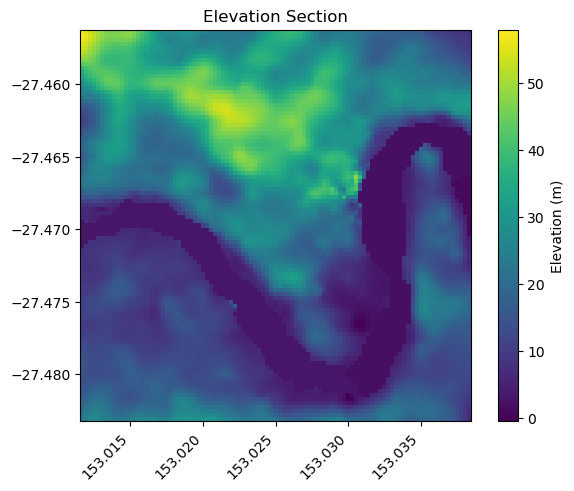

In [35]:
w.Elevation.plot_elevation()

As you can see from the `%time` runtime outputs, each query is close to instant making owing to how `wombat` access the 80GB ELVIS TIF of Australia (using GDAL).

# Viewsheds

Coming soon...